# Data Challenge SD207
 **by Wissem HAMIDOU & Benjamin LAZARD**
 
The present file was made under python 3.6. 

This file is the combined results of 2 students' work, made more readable to someone else, and therefore, though we tried to put it in order, it is possible for some cells to be the result of a study not kept in memory.
It is not the exact set of trials we ran, but a simplified version for the sake of conciseness and time economy, where not all cells were run .

It is important to notice, particularly at the end of the file, that we tried to tune the hyper-parameters at best even if it is not necerraily reflected here. 


## A few useful imports

In [1]:
# basic python packages for plotting and array management
import numpy as np
import matplotlib.pyplot as plt
import itertools

# for data import
import pandas as pd
from os import listdir

#to process the data from raw ".wav" input into a numerical file fit to data analysis
import librosa as audio
import librosa.display as audiodisplay

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Classifiers retained
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GMM

# Ensemble methods and crossvalidation
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score

# PostProcessing
from sklearn.metrics import confusion_matrix

# Because oh boy some computations take an amazing amount of time !
from time import time
from progress_bar import InitBar

# Data import

- First we will start by retrieving the names of the files associated to each dataset (**training**, **validation**, and **test**), with a structure aimed at remembering the labels.
- Then we establish a list of labels, so that to each *name*, a single *number* is mapped.
- Eventually given a *fusion mode*, we retrieve all files.

Given an audio file, the library **librosa**, imported as *audio* here, will return a matrix of size(number of MFCC components, number of timeframes). As the number of timeframes is not supposed to be the same for each file, for the purpose of facilitating *late fusion*, we will consider the transposed version fo this matrix, which allows for vertical packing of these matrixes.

## Retrieving file names and labels

In [2]:
######################################################################
#Importing a panda list of file_names vs labels for each specific data_set

########## Train set
train_labels_list = pd.read_table("data/train.txt", sep='\s+', names=['file', 'label'])
train_labels_list['file'] = (train_labels_list.file.str.replace(r'(audio/)', ''))

########## Validation set
validation_labels_list = pd.read_table("data/dev.txt", sep='\s+', names=['file', 'label'])
validation_labels_list['file'] = (validation_labels_list.file.str.replace(r'(audio/)', ''))

########## Test set
test_labels_list = pd.read_table("data/test_files.txt", sep='\s+', names=['file'])
test_labels_list['file'] = (test_labels_list.file.str.replace(r'(audio/)', ''))

print("training items: %d, validation items: %d, test items: %d"%(train_labels_list.count()['file'] , validation_labels_list.count()['file'], test_labels_list.count()['file']))

######################################################################
#Defining labels:
corresponding_label = ["beach", "bus", "cafe/restaurant", "car", "city_center", "forest_path", 
                                "grocery_store", "home", "library", "metro_station", "office", "park", 
                               "residential_area", "train", "tram"]

training items: 582, validation items: 290, test items: 298


Let us check whether there are some **NaN** values, and see what the data we have now is like

In [16]:
#check the existence of Null values
print("check for NaN values:")
print(train_labels_list.isnull().values.any())
print(validation_labels_list.isnull().values.any(), "\n")

#see what the lists are like
print("train data and labels:")
print(train_labels_list[0:12], "\n")
print("test data and labels:")
print(test_labels_list[0:12])

check for NaN values:
False
False 

train data and labels:
                file  label
0      b010_0_30.wav  beach
1     b010_60_90.wav  beach
2   b010_150_180.wav  beach
3     b010_30_60.wav  beach
4   b010_120_150.wav  beach
5   b022_120_150.wav  beach
6     b022_60_90.wav  beach
7   b022_180_210.wav  beach
8     b022_30_60.wav  beach
9    b022_90_120.wav  beach
10  b022_150_180.wav  beach
11     b022_0_30.wav  beach 

test data and labels:
                file
0      b053_0_30.wav
1    b035_90_120.wav
2   b089_210_240.wav
3     a034_30_60.wav
4   a045_150_180.wav
5    a058_90_120.wav
6     b029_60_90.wav
7     a079_30_60.wav
8   b055_137_167.wav
9   b049_150_180.wav
10    b053_30_60.wav
11  b018_120_150.wav


# A few useful functions

To automate the many procedures used later to try out different classifiers.
The score will be simply the accuracy of the classification algorithm:

$100 \times \frac1{N}\sum_{i=1}^N \mathbb{1} (y_i = \hat{y}_i)$,

where $N$ is the number of test instances, $y_i$ denotes the true test labels and $\hat{y}_i$ denotes the estimation of your algorithm.


the rule used to classify a late fusionned matrix is a majority rule : for each time sample of the file, which category is assigned most of the time ?

- compute the score
- beautify time count
- prepare the dataset (scale it, operate a PCA, shuffle the training set)
- go back from a late fusion with timeframe classification to a file classification
- save prediction to a text file

In [3]:
def compute_pred_score(y_true, y_pred):
    y_true = np.array(y_true)# conversion to allow for element-wise comparison
    y_pred = np.array(y_pred)
    y_pred_unq = np.unique(y_pred)
    for i in y_pred_unq:
        if(i not in range(0,15)):
            raise ValueError('Some predictions are out of range')
    y_comp = (y_true == y_pred)
    score = 100 * np.sum(y_comp) / len(y_comp)
    return score


def makeTimeSignificant(t_seconds):
    # transforms seconds into hours, minutes, and seconds
    m, s = divmod(t_seconds, 60)
    h, m = divmod(m, 60)
    return "%dh%02dm%02ds" % (h, m, s)

def prepare_dataset(XX_train, y_train, XX_val, yy_val, XX_test, var_ratio_min=99.9, ratio_sd=100):
    # Scale the training set
    myScaler = StandardScaler()
    XX_train_scaled = myScaler.fit_transform(XX_train)

    # Select the most significant features
    pca_scaled = PCA(svd_solver='full', whiten=True, n_components=var_ratio_min/100).fit(XX_train_scaled)
    XX_pca_scaled = pca_scaled.transform(XX_train_scaled)
    print("%d features selected out of %d (%d %%) for PCA which explains %d %% of variance" % (pca_scaled.n_components_, XX_train.shape[1], pca_scaled.n_components_/XX_train.shape[1]*100, pca_scaled.explained_variance_ratio_.sum()*100))

#     print("\n explained variance ratio as a 'per thousand' ratio for each of the selected features")
#     print((pca_scaled.explained_variance_ratio_*1000).round())

    # Select a certain amount of observations
    n_sd = XX_train.shape[0]*ratio_sd/100  # effective number of observations retained
    print("%d observations selected out of %d (%d %%) for Shuffling and training" % (n_sd, XX_train.shape[0], ratio_sd))

    # Shuffle it
    XX_train_scaled_shuffled, yy_train_scaled_shuffled = shuffle(XX_pca_scaled, y_train, n_samples=n_sd)

    # Adapt the validation set accordingly
    XX_val_scaled = myScaler.transform(XX_val)
    XX_val_scaled_pca = pca_scaled.transform(XX_val_scaled)
      # no need to shuffle the validation set
    
    # Adapt the test set accordingly
    XX_test_scaled = myScaler.transform(XX_test)
    XX_test_scaled_pca = pca_scaled.transform(XX_test_scaled)

    return XX_train_scaled_shuffled, yy_train_scaled_shuffled, XX_val_scaled_pca, yy_val, XX_test_scaled_pca

#plot the confusion matrix given sklearn confusion matrix, and the set of classes
def plot_confusion_matrix(cm, classes, title="", cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Converts an array of unshuffled late fusionned matrix into an array which classifies each file
def Late2File(file_size, y_late):
    nbfiles = len(y_late)/file_size
    if (int(nbfiles)!= nbfiles):
        print("ERROR in Late2File : the file_size is not compatible with the vector")
        return
    
    y_file = []
    print(nbfiles)
    for i in range(int(nbfiles)):
        subset = y_late[i*file_size:((i+1)*file_size-1)]
        most_common = max(set(subset), key=subset.count)
        y_file.append(most_common)
    
    return y_file

#find the elements that appear the most in an array (of integers here)
def most_common(lst):
    return max(set(lst), key=lst.count)

#same as Late2File, with a different paradigm : the number of files is given instead of its size
def regenerate(l, N_files):
    l_new = []
    l = l.tolist()
    a = int(len(l)/N_files)
    for i in range (N_files):
        m = most_common(l[a * i : a * (i+1)])
        l_new.append(m)
    return l_new

def save_prediction(y_pred, trial_number, threshold=0.7):
    np.savetxt('y_pred_' + str(trial_number) + '.txt', y_pred, fmt='%d')
    

# Trying out MFCC audio features extraction

the file obtained with n_fft=512 and hop_length=512 is a matrix of size 1292x20 obtained in 0h00m00s


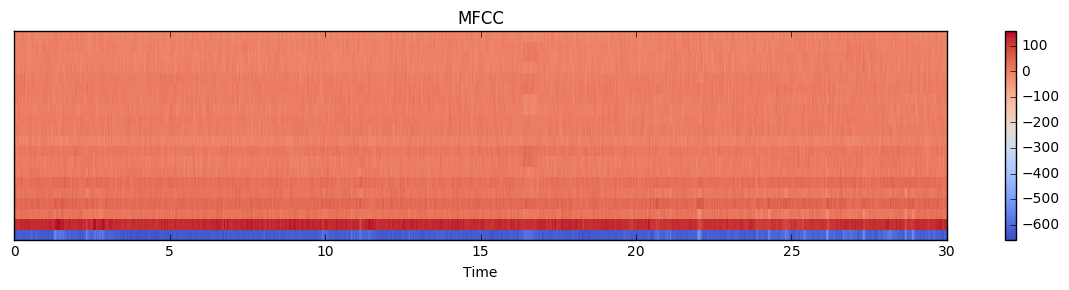

the file obtained with n_fft=1024 and hop_length=512 is a matrix of size 1292x20 obtained in 0h00m00s


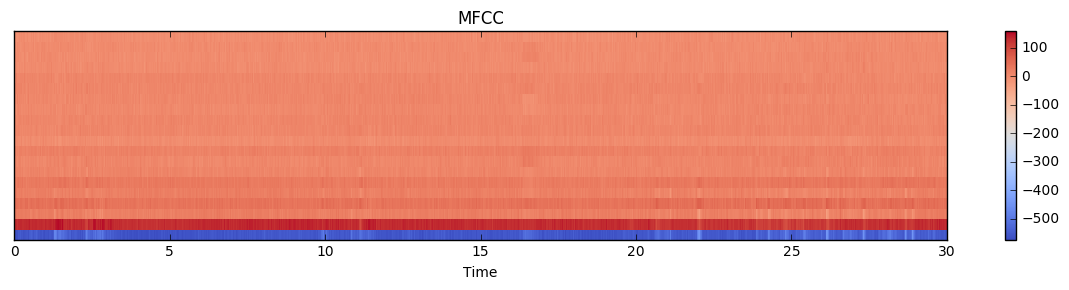

the file obtained with n_fft=1024 and hop_length=128 is a matrix of size 5168x20 obtained in 0h00m00s


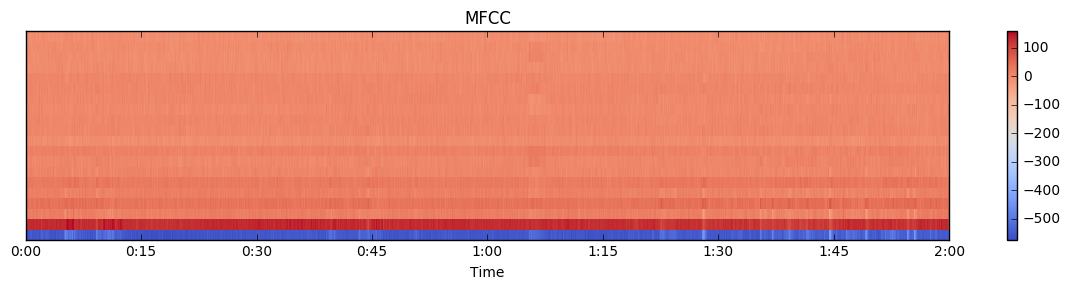

the file obtained with n_fft=1024, n_mfcc=30 and hop_length=128 is a matrix of size 5168x30 obtained in 0h00m00s


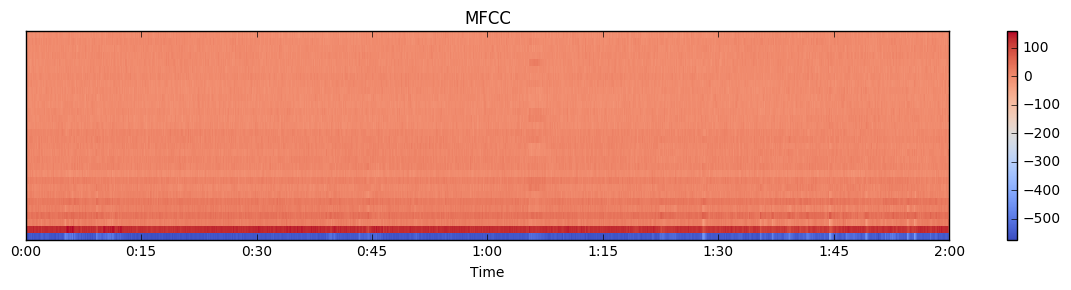

the file obtained with n_fft=1024, n_mfcc=40 and hop_length=128 is a matrix of size 2584x40 obtained in 0h00m00s


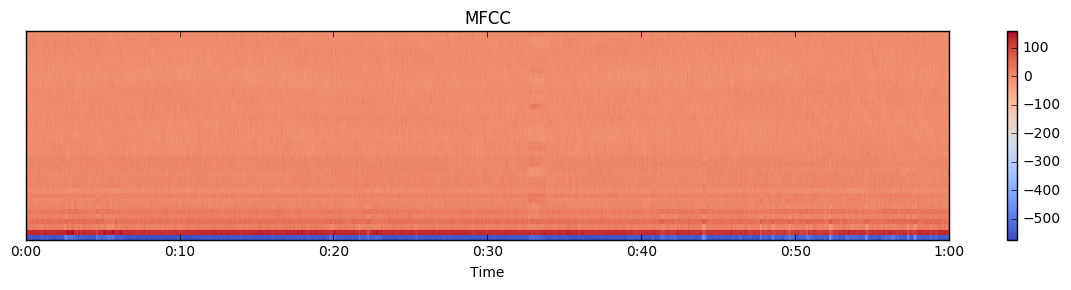

In [119]:
#Select a file
filename = "data/" + train_labels_list.file[30]

#Operate audio analysis
timeseries, sampleRate = audio.load(filename)# load the audio file
t = time()
X_file = audio.feature.mfcc(y=timeseries, 
                            sr=sampleRate,
                            n_fft=2**9, 
                            hop_length=512,
                            n_mfcc=20).T # the file corresponding to the current row
#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**9,
                                                                                                   512,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

######################################################################
#impact of n_fft
#Operate another audio analysis
t = time()
X_file = audio.feature.mfcc(y=timeseries, 
                            sr=sampleRate,
                            n_fft=2**10, 
                            hop_length=512,
                            n_mfcc=20).T # the file corresponding to the current row
#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                   512,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

######################################################################
#impact of hop_length
#Operate another audio analysis
t = time()
X_file = audio.feature.mfcc(y=timeseries, 
                            sr=sampleRate,
                            n_fft=2**10, 
                            hop_length=2**7,
                            n_mfcc=20).T # the file corresponding to the current row
#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                   2**7,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

######################################################################
#impact ofn_mfcc
#Operate another audio analysis
t = time()
X_file = audio.feature.mfcc(y=timeseries, 
                            sr=sampleRate,
                            n_fft=2**10, 
                            hop_length=2**7,
                            n_mfcc=30).T # the file corresponding to the current row
#print out properties
print("the file obtained with n_fft=%d, n_mfcc=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                               30,
                                                                                                   2**7,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

#Operate another audio analysis
t = time()
X_file = audio.feature.mfcc(y=timeseries, 
                            sr=sampleRate,
                            n_fft=2**10, 
                            hop_length=2**8,
                            n_mfcc=40).T # the file corresponding to the current row
#print out properties
print("the file obtained with n_fft=%d, n_mfcc=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                               40,
                                                                                                   2**7,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

**Conclusions:**
- Each MFCC processing leads to a matrix of size *N_timeframes* x *N_mfccfeatures*.
Graphically, and after trying out the analysis on different files, it seems that choosing too many MFCC features is not necessarily helpful.
- Having a bigger fft or a smaller hop_length seems to introduce parcimony.

So eventually, **MFCC=30, n_fft = 1024, hop=n_fft** seems a good first choice.

# trying out chroma stft

the file obtained with n_fft=1024 and hop_length=128 is a matrix of size 5168x12 obtained in 0h00m00s


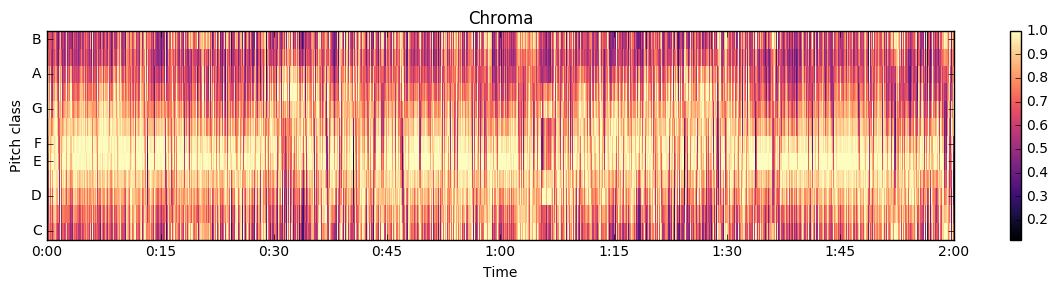

the file obtained with n_fft=1024 and hop_length=2048 is a matrix of size 323x12 obtained in 0h00m00s


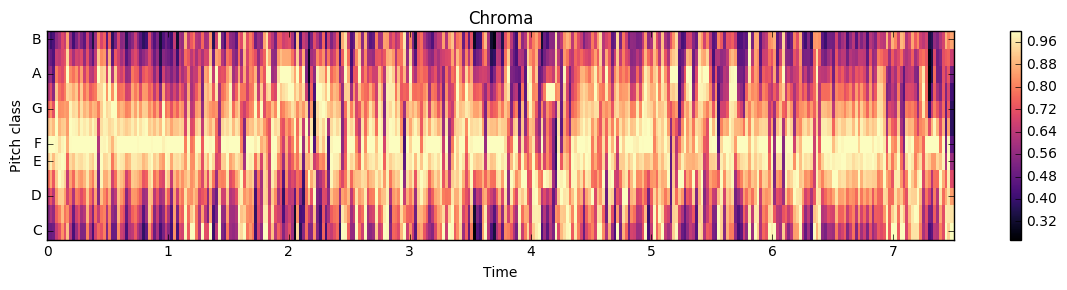

the file obtained with n_fft=2048 and hop_length=2048 is a matrix of size 323x12 obtained in 0h00m00s


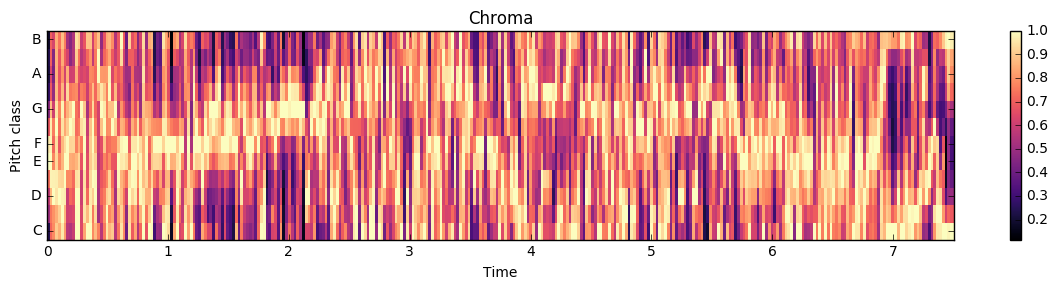

In [146]:
#Select a file
filename = "data/" + train_labels_list.file[30]
timeseries, sampleRate = audio.load(filename)# load the audio file

#Operate an audio analysis
t = time()
X_file = audio.feature.chroma_stft(y= timeseries, 
                                   sr=sampleRate,
                                   hop_length = 2**7,
                                   n_fft = 2**10).T # the file corresponding to the current row

#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                   2**7,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

######################################################################
#impact of hop_length
#Operate another audio analysis
t = time()
X_file = audio.feature.chroma_stft(y= timeseries, 
                                   sr=sampleRate,
                                   hop_length = 2**11,
                                   n_fft = 2**10).T # the file corresponding to the current row

#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                   2**11,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

######################################################################
#impact of n_fft
#Operate another audio analysis
t = time()
X_file = audio.feature.chroma_stft(y= timeseries, 
                                   sr=sampleRate,
                                   hop_length = 2**11,
                                   n_fft = 2**11).T # the file corresponding to the current row

#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**11,
                                                                                                   2**11,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

**Conclusions:**
- Each chroma analysis processing leads to a matrix of size *N_timeframes* x *PiTch classes*.
Graphically, and after trying out the analysis on different files, it seems that a higher FFT leads to a higehr parcimony
- Having a gretaer hop_length leads to better averaging

So eventually, **n_fft = 2048, hop=1024** seems a good first choice.

# trying out melspectrogram

the file obtained with n_fft=1024 and hop_length=128 is a matrix of size 646x128 obtained in 0h00m00s


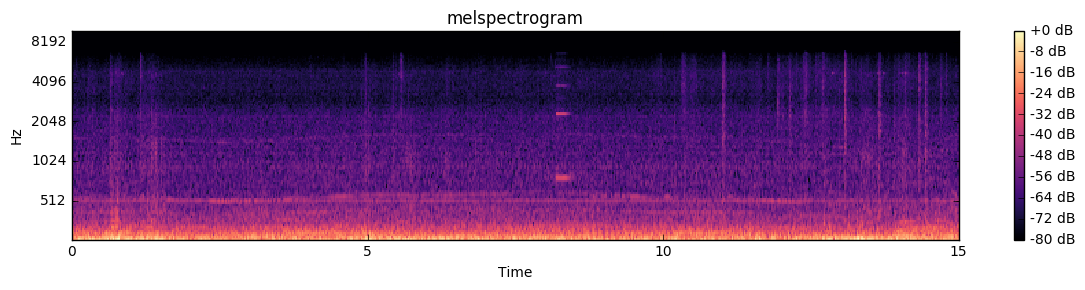

In [144]:
#Select a file
filename = "data/" + train_labels_list.file[30]
timeseries, sampleRate = audio.load(filename)# load the audio file

#Operate an audio analysis
t = time()
X_file = audio.feature.melspectrogram(y= timeseries, 
                                      sr=sampleRate,
                                      hop_length = 2**10,
                                      n_fft = 2**10).T # the file corresponding to the current row

X_file = audio.power_to_db(X_file, ref = np.max)

#print out properties
print("the file obtained with n_fft=%d and hop_length=%d is a matrix of size %dx%d obtained in %s"%(2**10,
                                                                                                   2**7,
                                                                                                   X_file.shape[0], 
                                                                                                   X_file.shape[1],
                                                                                                   makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
audiodisplay.specshow(X_file.T, x_axis='time', y_axis='mel', fmax=10000)
plt.colorbar(format='%+2.0f dB')
plt.title('melspectrogram')
plt.tight_layout()
plt.show()

It looks a lot like MFCC, maybe cleaner. tuning did not seem to introduce major changes.

# trying out spectral contrast

the file obtained is a matrix of size 1292x1 obtained in 0h00m00s


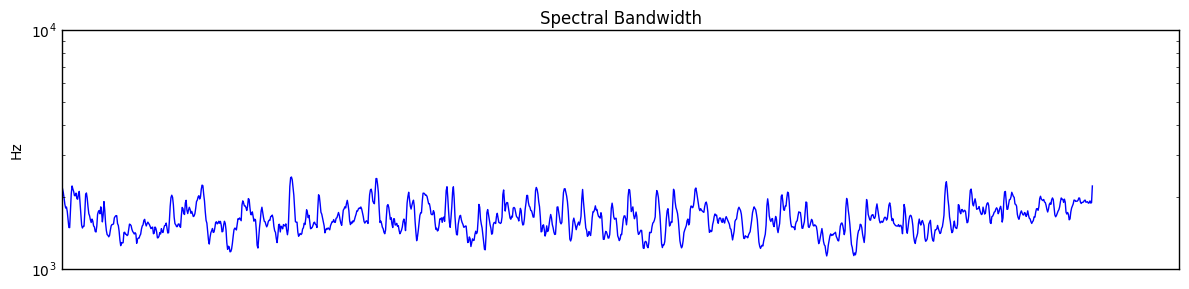

In [150]:
#Select a file
filename = "data/" + train_labels_list.file[40]
timeseries, sampleRate = audio.load(filename)# load the audio file

#Operate an audio analysis
t = time()
X_file = audio.feature.spectral_bandwidth(y= timeseries, sr=sampleRate).T # the file corresponding to the current row

#print out properties
print("the file obtained is a matrix of size %dx%d obtained in %s"%(X_file.shape[0], 
                                                                    X_file.shape[1],
                                                                    makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
plt.title('Spectral Bandwidth')
plt.semilogy(X_file)
plt.ylabel('Hz')
plt.xticks([])
plt.tight_layout()
plt.show()

It looks very simple to handle, as it is just a vector, and does show variations from a file to another. Therefore ist must be tested.

# trying out chroma cens

the file obtained is a matrix of size 1292x12 obtained in 0h00m00s


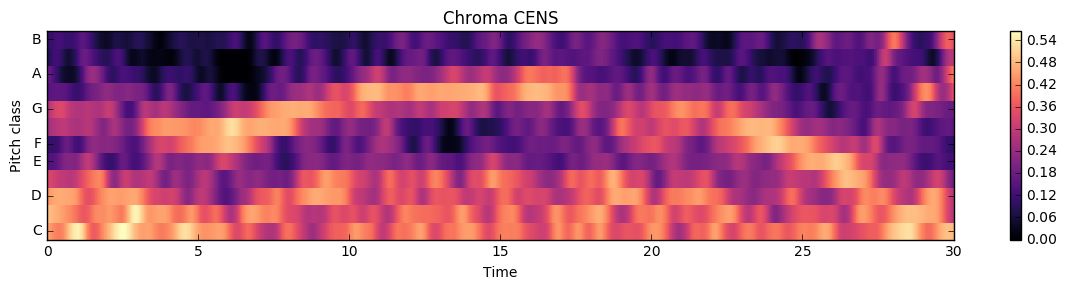

In [157]:
#Select a file
filename = "data/" + train_labels_list.file[30]
timeseries, sampleRate = audio.load(filename)# load the audio file

#Operate an audio analysis
t = time()
X_file = audio.feature.chroma_cens(y= timeseries, sr=sampleRate).T # the file corresponding to the current row

#print out properties
print("the file obtained is a matrix of size %dx%d obtained in %s"%(X_file.shape[0], 
                                                                    X_file.shape[1],
                                                                    makeTimeSignificant(time()-t)))

#display it
plt.figure(figsize=(12, 3))
plt.title('Chroma CENS')
audiodisplay.specshow(X_file.T, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()

The default parameters seemed the most relevant (some variance, not too much data... To be tested)

# Trying a simple Classification

## Idea:
- late fusion with a low number of MFCC
- MLP Classifier (because usually both fast and good)

### First getting the different datasets
Retrieving the features corresponding to each file

In [4]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
MFCC_features = 35
hop_length_features = 2**10
FFT_window_features = 2**10

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features) #perform the MCC analysis
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)

  [=================================99.8%==================================]

files loaded in 0h07m37s
Train shape (545916, 35) validation shape (272020, 35) test shape (279524, 35)


### Then prepare them and operate classification

In [203]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    alpha=1, 
                    solver= 'lbfgs',
                    random_state=1,
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 5)

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h09m19s
score = 64 %


# Now trying with other features
## use melspectrograms

In [172]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
hop_length_features = 2**10
FFT_window_features = 2**10

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)

  [=================================99.8%==================================]

files loaded in 0h04m23s
Train shape (272958, 128) validation shape (136010, 128) test shape (139762, 128)


### Prepare them and classify

In [174]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    alpha=1, 
                    solver= 'lbfgs',
                    random_state=1,
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 2)

127 features selected out of 128 (99 %) for PCA which explains 99 % of variance
272958 observations selected out of 272958 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h05m27s
score = 64 %


## now with chroma_cens

In [176]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.chroma_cens(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.chroma_cens(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.chroma_cens(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)


  [====>                             5.4%                                  ]C:\Users\Benjamin\Anaconda3\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
  [=================================99.8%==================================]

files loaded in 0h11m44s
Train shape (545916, 12) validation shape (272020, 12) test shape (279524, 12)


### Prepare them and classify

In [177]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    alpha=1, 
                    solver= 'lbfgs',
                    random_state=1,
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 3)

12 features selected out of 12 (100 %) for PCA which explains 99 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h10m00s
score = 36 %


This is rather discouraging !!
# using spectral bandwidth

In [200]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of Bandwidth features

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.spectral_bandwidth(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_train_raw = X_file
        y_train_raw = [corresponding_label.index(filename.label)] 
    else:#concatenate data under the "late fusion" model
        X_train_raw = np.r_[X_train_raw, X_file]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.spectral_bandwidth(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_validation_raw = X_file
        y_validation_raw = [corresponding_label.index(filename.label)] 
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.spectral_bandwidth(y= timeseries, sr= sampleRate) #perform the MCC analysis
    if i==0:
        X_test_raw = X_file
    else:
        X_test_raw = np.r_[X_test_raw, X_file]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)


  [=================================99.8%==================================]

files loaded in 0h03m20s
Train shape (582, 938) validation shape (290, 938) test shape (298, 938)


### preparing and clasifying

In [201]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    alpha=1, 
                    solver= 'lbfgs',
                    random_state=1,
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 4)

526 features selected out of 938 (56 %) for PCA which explains 99 % of variance
582 observations selected out of 582 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h00m00s
score = 10 %


## Trying "no fusion" on a few timeframes
The idea is to reuse the melspectrum intent, by concatenating a few close timeframes into single observations

In [256]:
######################################
#function that converts a melspectrogram into a combination of "no" and "late" fusion
def benjifusion(X_file, ntimeframes=20):
    if X_file.shape[1] > X_file.shape[0]:
        print("ERROR the X_file should have been transposed in benjifusion()")
        return
    nsub = int(X_file.shape[0]/ ntimeframes)
    tmp = np.array(X_file[0:ntimeframes-1, :]).ravel()
    for i in range(nsub-1):
        tmp = np.c_[tmp, np.array(X_file[ntimeframes*(i+1):ntimeframes*(i+2)-1, :]).ravel()] 
    tmp = tmp.T 
    return tmp

#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
hop_length_features = 2**10
FFT_window_features = 2**10

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    X_file = benjifusion(X_file.T).T
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
#         print(X_train_raw.shape, y_train_raw.shape)
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    X_file = benjifusion(X_file.T).T
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.melspectrogram(y= timeseries, sr= sampleRate, n_fft=FFT_window_features, hop_length=hop_length_features) #perform the MCC analysis
    X_file = audio.power_to_db(X_file, ref = np.max)
    X_file = benjifusion(X_file.T).T
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)


  [                                  0.1%                                  ]

(23, 2432) (23,)


  [=================================99.8%==================================]

files loaded in 0h04m45s
Train shape (13386, 2432) validation shape (6670, 2432) test shape (6854, 2432)


### and classification

In [260]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(1000, 100), tol=2e-3)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 6)

2401 features selected out of 2432 (98 %) for PCA which explains 99 % of variance
13386 observations selected out of 13386 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h02m15s
score = 53 %


As this is much worse than with the first late fusion model, (even with a "bigger" MLP, aimed at taking into account the change in information)
We will stick to the late fusion model, and try to optimize it with a gridsearch.

# MLP optimisation

Let us reuse the late fusion with MFCC as it is what yielded the best results so far.
It seems that packing timeframes together was not a good idea, therefore we will not try to pack together several techniques of signal processing such as MFCC and Melspectrum or chroma, as the timeframe sampling is very different from a method to another. It would be hard to operate a proper feature set per observations.

As this a fast classifier, we will first focus our attention on it, then only study other estimators

In [261]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
MFCC_features = 35
hop_length_features = 2**10
FFT_window_features = 2**10

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features) #perform the MCC analysis
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)

  [=================================99.8%==================================]

files loaded in 0h04m15s
Train shape (545916, 35) validation shape (272020, 35) test shape (279524, 35)


## Trying out a LDA analysis before MLP analysis

This was recommanded as a possible optimization [here](https://www.kaggle.com/aniruddhaachar/data-visualization-and-machine-learning-algorithms).

It is possible to use it pretty much like a PCA : a projection in an optimized space where data is supposed to be more seprable, except it is supervised.

In [296]:
################# Trying out LDA instead of PCA for data analysis
def prepare_dataset_lda(XX_train, y_train, XX_val, yy_val, XX_test, var_ratio_min=99.9, ratio_sd=100):
    # Scale the training set
    myScaler = StandardScaler()
    XX_train_scaled = myScaler.fit_transform(XX_train)

    # Select the most significant features using a LDA
    lda = LDA(n_components= XX_train.shape[1])
    lda.fit(XX_train_scaled, y_train)
    
    XX_lda_scaled = lda.transform(XX_train_scaled)

    # Select a certain amount of observations
    n_sd = XX_train.shape[0]*ratio_sd/100  # effective number of observations retained
    print("%d observations selected out of %d (%d %%) for Shuffling and training" % (n_sd, XX_train.shape[0], ratio_sd))

    # Shuffle it
    XX_train_scaled_shuffled, yy_train_scaled_shuffled = shuffle(XX_lda_scaled, y_train, n_samples=n_sd)

    # Adapt the validation set accordingly
    XX_val_scaled = myScaler.transform(XX_val)
    XX_val_scaled_lda = lda.transform(XX_val_scaled)
      # no need to shuffle the validation set
    
    # Adapt the test set accordingly
    XX_test_scaled = myScaler.transform(XX_test)
    XX_test_scaled_lda = lda.transform(XX_test_scaled)

    return XX_train_scaled_shuffled, yy_train_scaled_shuffled, XX_val_scaled_lda, yy_val, XX_test_scaled_lda

####################################
#Standardize, shuffle, LDA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset_lda(XX_train=X_train_raw, 
                                                 y_train= y_train_raw, 
                                                 XX_val= X_validation_raw, 
                                                 yy_val= y_validation_raw, 
                                                 XX_test=X_test_raw, 
                                                 ratio_sd=100, 
                                                 var_ratio_min=99.9)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    alpha=1, 
                    solver= 'lbfgs',
                    random_state=1,
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298),  7)

545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


files fitted in 0h09m10s
score = 64 %


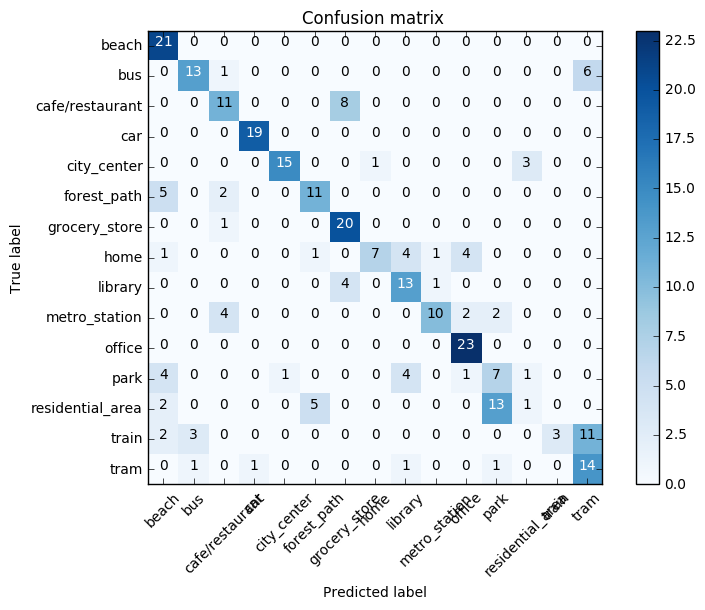

In [297]:
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

There was unfortunately not significant improvement, this is why we will forget it at the moment
Nonetheless, we will try a LDA classification later.
The confusion matrix leads to the idea we may try an outlier procedure removal in vain, since most confusions involve many elements. 

## grid search with a few different layers types

As there is cross valiadtion in grid search, we can concatenate the training and validation datasets to better off efficiency.

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 96.0min
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed: 132.3min remaining: 26.4min
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 274.1min finished
C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


files fitted in 5h32m37s

============best params found 
 {'hidden_layer_sizes': (200, 200)}

============Classification report


C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


   rank test  score test  score train      layers
5          1    0.756412     0.950907  (200, 200)
4          2    0.751886     0.912603      (300,)
2          3    0.738940     0.901508      (200,)
0          4    0.731819     0.878296      (100,)
3          5    0.729641     0.881304    (50, 50)
1          6    0.700402     0.845889       (50,)
score = 100 %


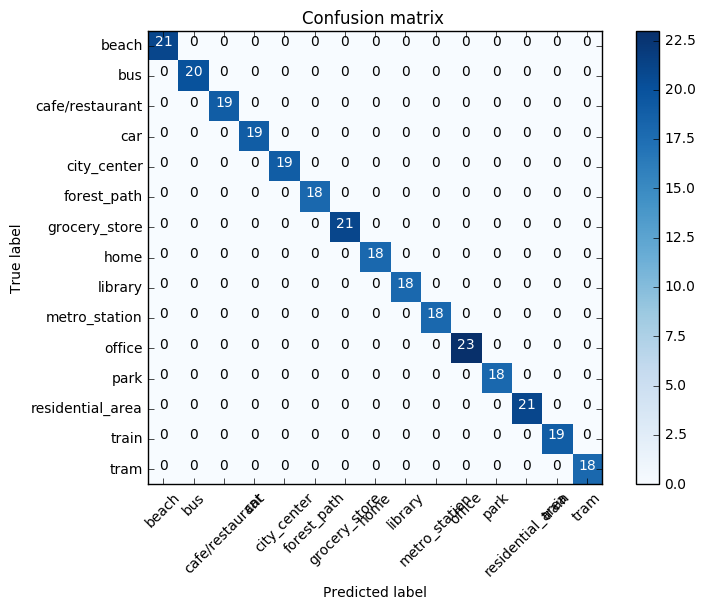

In [301]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the gridsearch parameters
param_grid = [{'hidden_layer_sizes': [(100,), (50,), (200,), (50,50), (300,), (200,200)]}]

####################################
#define the classifier
clf = MLPClassifier()
#the grid
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=4, verbose=5)

####################################
#training
start = time()
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_t, y_v), axis=0) #concatenating the training and validaton test
grid.fit(X_tc, y_tc)
print("files fitted in %s"%(makeTimeSignificant(time()-start)))

###################################
#Feedback on the best parameters, and each parameter performance:
print("\n============best params found \n %a"%(grid.best_params_))
print('\n============Classification report')
results = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'mean_train_score',
                                          'param_hidden_layer_sizes'
                                         ]]
results.columns = ['rank test', 'score test', 'score train','layers']
results = results.sort(columns='rank test', ascending=True)
print(results)

####################################
#prediciton on timeframes
y_pred = grid.best_estimator_.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing a score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

####################################
#saving prediction
save_prediction(regenerate(grid.best_estimator_.predict(X_test),290), 8)

Based on this study, I will try even bigger layers

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 644.4min remaining: 322.2min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 998.8min finished
C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


files fitted in 18h42m24s

============best params found 
 {'hidden_layer_sizes': (200, 200)}

============Classification report


C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


   rank test  score test  score train      layers
0          1    0.757210     0.951384  (200, 200)
3          2    0.751619     0.988577  (500, 500)
2          3    0.751427     0.918798      (400,)
1          4    0.747763     0.975833  (300, 300)
score = 100 %


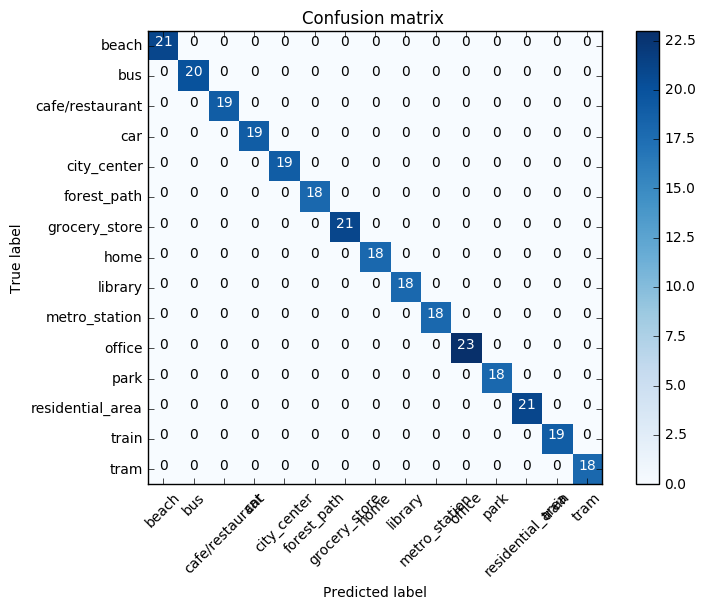

In [ ]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the gridsearch parameters
param_grid = [{'hidden_layer_sizes': [(200, 200), (300, 300), (400,), (500,500)]}]

####################################
#define the classifier
clf = MLPClassifier()
#the grid
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=4, verbose=5)

####################################
#training
start = time()
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_t, y_v), axis=0) #concatenating the training and validaton test
grid.fit(X_tc, y_tc)
print("files fitted in %s"%(makeTimeSignificant(time()-start)))

###################################
#Feedback on the best parameters, and each parameter performance:
print("\n============best params found \n %a"%(grid.best_params_))
print('\n============Classification report')
results = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'mean_train_score',
                                          'param_hidden_layer_sizes'
                                         ]]
results.columns = ['rank test', 'score test', 'score train','layers']
results = results.sort(columns='rank test', ascending=True)
print(results)

####################################
#prediciton on timeframes
y_pred = grid.best_estimator_.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing a score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

####################################
#saving prediction
save_prediction(regenerate(grid.best_estimator_.predict(X_test), 298), 9)

Based on this we will try either deeper layers with a smaller number of neurons per layer or stick to the (200, 200) model or similar models. Of course we should rather perform the grisearch on much more hyper-parameters at the same time, but it is way too time-consuming.

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 194.7min
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 227.8min finished


files fitted in 4h22m42s

============best params found 
 {'alpha': 0.001, 'hidden_layer_sizes': (100, 100)}

============Classification report


C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


   rank test  score test  score train      layers     alpha
1          1    0.754316     0.918719  (100, 100)     0.001
0          2    0.749652     0.948743  (200, 200)     0.001
3          3    0.735805     0.876143  (200, 200)  0.316228
2          4    0.731573     0.879122      (100,)     0.001
4          5    0.730699     0.871785  (100, 100)  0.316228
5          6    0.703181     0.835126      (100,)  0.316228
6          7    0.068807     0.068807  (200, 200)       100
8          7    0.068807     0.068807      (100,)       100
7          9    0.068426     0.068425  (100, 100)       100
score = 100 %


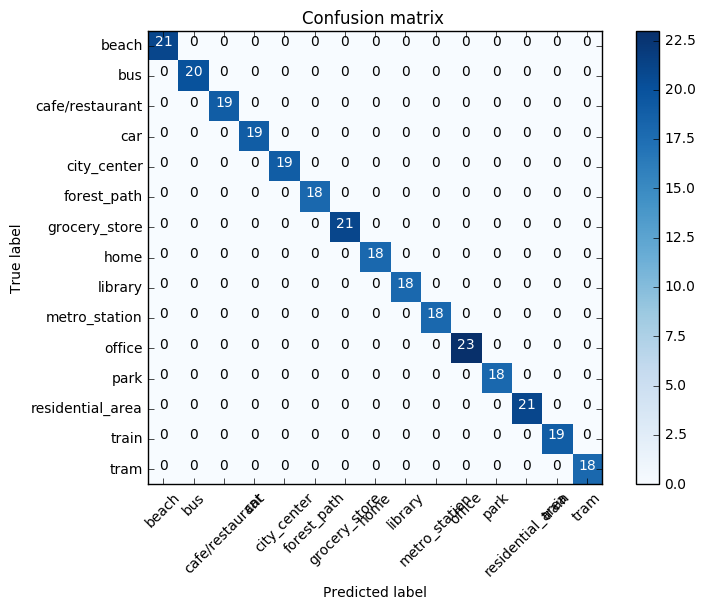

In [6]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the gridsearch parameters
param_grid = [{'hidden_layer_sizes': [(200, 200), (100,100), (100,)],
               'alpha' : np.logspace(-3, 2, 3)}]

####################################
#define the classifier
clf = MLPClassifier()
#the grid
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=4, verbose=5)

####################################
#training
start = time()
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_t, y_v), axis=0) #concatenating the training and validaton test
grid.fit(X_tc, y_tc)
print("files fitted in %s"%(makeTimeSignificant(time()-start)))

###################################
#Feedback on the best parameters, and each parameter performance:
print("\n============best params found \n %a"%(grid.best_params_))
print('\n============Classification report')
results = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'mean_train_score',
                                          'param_hidden_layer_sizes',
                                          'param_alpha'
                                         ]]
results.columns = ['rank test', 'score test', 'score train','layers', 'alpha']
results = results.sort(columns='rank test', ascending=True)
print(results)

####################################
#prediciton on timeframes
y_pred = grid.best_estimator_.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing a score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

####################################
#saving prediction
save_prediction(regenerate(grid.best_estimator_.predict(X_test), 298), 10)

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 250.5min
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 912.9min finished


files fitted in 16h14m56s

============best params found 
 {'alpha': 0.01, 'hidden_layer_sizes': (200, 200)}

============Classification report
    rank test  score test  score train           layers        alpha
9           1    0.766137     0.941149       (200, 200)         0.01
6           2    0.760259     0.947002       (200, 200)   0.00215443
11          3    0.759793     0.926847  (100, 100, 100)         0.01
5           4    0.758970     0.932241  (100, 100, 100)  0.000464159
8           5    0.757447     0.929836  (100, 100, 100)   0.00215443
7           6    0.757337     0.916256       (100, 100)   0.00215443
2           7    0.756598     0.931902  (100, 100, 100)       0.0001
1           8    0.754349     0.917118       (100, 100)       0.0001
4           9    0.753928     0.917748       (100, 100)  0.000464159
0          10    0.752644     0.949080       (200, 200)       0.0001
3          11    0.751905     0.950364       (200, 200)  0.000464159
10         12    0.751415   

C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


score = 100 %


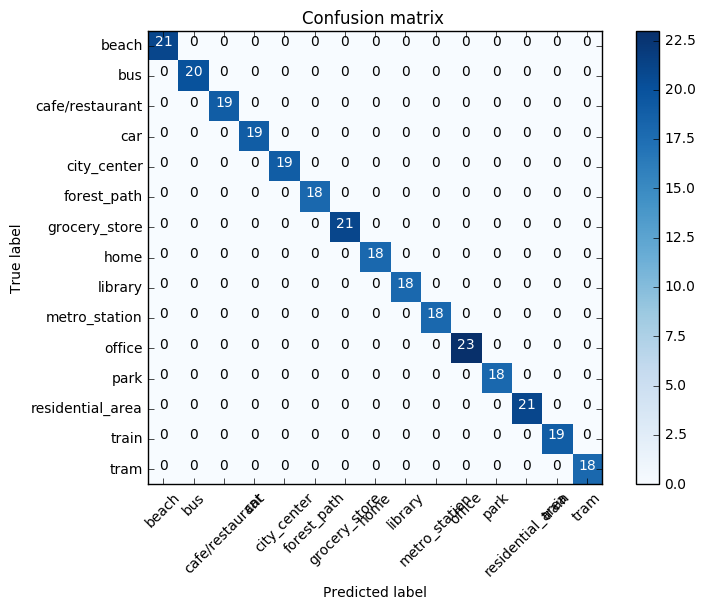

In [8]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the gridsearch parameters
param_grid = [{'hidden_layer_sizes': [(200, 200), (100,100), (100, 100, 100)],
               'alpha' : np.logspace(-4, -2, 4)}]

####################################
#define the classifier
clf = MLPClassifier()
#the grid
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=4, verbose=5)

####################################
#training
start = time()
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_t, y_v), axis=0) #concatenating the training and validaton test
grid.fit(X_tc, y_tc)
print("files fitted in %s"%(makeTimeSignificant(time()-start)))

###################################
#Feedback on the best parameters, and each parameter performance:
print("\n============best params found \n %a"%(grid.best_params_))
print('\n============Classification report')
results = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'mean_train_score',
                                          'param_hidden_layer_sizes',
                                          'param_alpha'
                                         ]]
results.columns = ['rank test', 'score test', 'score train','layers', 'alpha']
results = results.sort(columns='rank test', ascending=True)
print(results)

####################################
#prediciton on timeframes
y_pred = grid.best_estimator_.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing a score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

####################################
#saving prediction
save_prediction(regenerate(grid.best_estimator_.predict(X_test), 298), 11)

There seems to be some overfitting despite the choice of alpha. This assomption was made noticing the score on the test set is below 70%.
Below, we will however try to study in depth the alpha and tolerance parameters.

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed: 228.8min remaining: 163.5min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed: 266.8min remaining: 70.2min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 277.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 277.3min finished


files fitted in 5h52m21s

============best params found 
 {'tol': 0.0001, 'alpha': 0.046415888336127795, 'hidden_layer_sizes': (200, 200)}

============Classification report


C:\Users\Benjamin\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


   rank test  score test  score train      layers       alpha     tol
2          1    0.761047     0.923304  (200, 200)   0.0464159  0.0001
1          2    0.759282     0.937700  (200, 200)  0.00316228   0.001
3          3    0.758138     0.916149  (200, 200)   0.0464159   0.001
0          4    0.755789     0.944769  (200, 200)  0.00316228  0.0001
4          5    0.713442     0.843624  (200, 200)    0.681292  0.0001
5          6    0.712367     0.843098  (200, 200)    0.681292   0.001
7          7    0.497354     0.567814  (200, 200)          10   0.001
6          8    0.495698     0.567618  (200, 200)          10  0.0001
score = 100 %


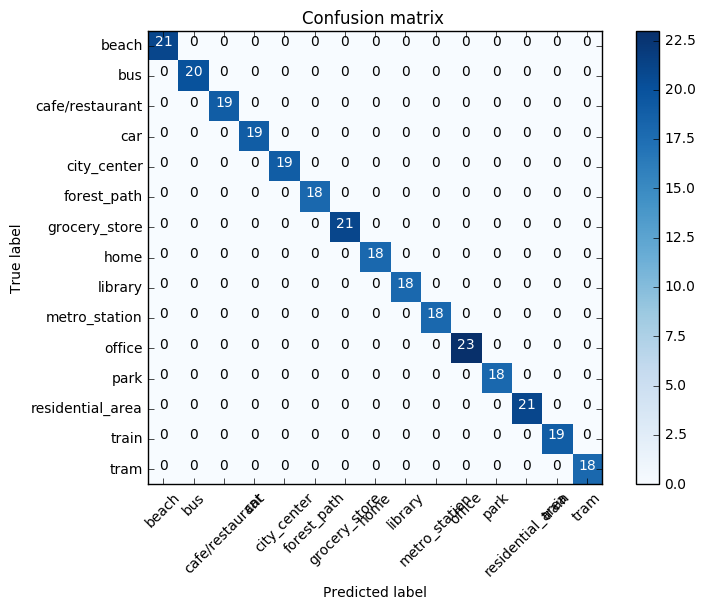

In [11]:
####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)

####################################
#define the gridsearch parameters
param_grid = [{'hidden_layer_sizes': [(200, 200)],
               'alpha' : np.logspace(-2.5, 1, 4),
               'tol' : [0.0001, 0.001]}]

####################################
#define the classifier
clf = MLPClassifier()
#the grid
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=5)

####################################
#training
start = time()
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_t, y_v), axis=0) #concatenating the training and validaton test
grid.fit(X_tc, y_tc)
print("files fitted in %s"%(makeTimeSignificant(time()-start)))

###################################
#Feedback on the best parameters, and each parameter performance:
print("\n============best params found \n %a"%(grid.best_params_))
print('\n============Classification report')
results = pd.DataFrame(grid.cv_results_)[['rank_test_score',
                                          'mean_test_score', 
                                          'mean_train_score',
                                          'param_hidden_layer_sizes',
                                          'param_alpha',
                                          'param_tol'
                                         ]]
results.columns = ['rank test', 'score test', 'score train','layers', 'alpha', 'tol']
results = results.sort(columns='rank test', ascending=True)
print(results)

####################################
#prediciton on timeframes
y_pred = grid.best_estimator_.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing a score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
#checkout my new trick ! 
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

####################################
#saving prediction
save_prediction(regenerate(grid.best_estimator_.predict(X_test), 298), 12)

We will try warm start, and multi-fitting,
then we will try standardization only (we realized it was necessarily worse than with pca and shuffling
then we will try another fusion mode, 
and then pass on to other techniques

### MLP without shuffling or projections

In [21]:
myscaler = StandardScaler()
X_t = myscaler.fit_transform(X_train_raw)
X_v = myscaler.transform(X_validation_raw)
X_test = myscaler.transform(X_test_raw)

####################################
#define the classifier
clf = MLPClassifier(hidden_layer_sizes=(200, 200),
                    alpha=0.046, 
                    warm_start=True)

####################################
#training
t = time()
clf.fit(X_t, y_t)
clf.fit(X_v, y_v)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 14)

files fitted in 2h39m32s
score = 52 %


Obviously, that was a terrible idea
### Bagging of MLP with personnalized early fusion

We perform here both a measure of mean and variance for the MFCC features of each file (over timeframes)

In [29]:
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
MFCC_features = 40
hop_length_features = 2**10
FFT_window_features = 2**10

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features) #perform the MCC analysis
    if i==0:
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_t = a
        y_t = corresponding_label.index(filename.label)*np.array([1])
    else:#concatenate data under the "late fusion" model
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_t = np.concatenate((X_t,  a))
        y_t = np.concatenate((y_t, 
                           corresponding_label.index(filename.label)*np.array([1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_v = a
        y_v = corresponding_label.index(filename.label)*np.array([1])
    else:
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_v = np.concatenate((X_v,  a))
        y_v = np.concatenate((y_v, 
                           corresponding_label.index(filename.label)*np.array([1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_test = a
    else:
        a = np.concatenate((X_file.T.mean(axis=0), X_file.T.var(axis=0)), axis =0)
        a = np.concatenate((a, np.median(X_file.T, axis=0)), axis=0)
        a = np.reshape(a.ravel() , (1, len(a)))
        X_test = np.concatenate((X_test,  a))
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_t.shape, y_t.shape, "validation shape", X_v.shape, y_v.shape,"test shape", X_test.shape)

####################################
#Standardize, shuffle, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_t, 
                                             y_train= y_t, 
                                             XX_val= X_v, 
                                             yy_val= y_v, 
                                             XX_test=X_test, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.9)
####################################
#classification with bagging of small MLP
t = time()
MLclf = MLPClassifier(hidden_layer_sizes=(200, 200), alpha=0.01, solver= 'lbfgs' ,random_state=1, warm_start=True)
clf = BaggingClassifier(MLclf, max_samples=0.4, max_features=0.6, n_estimators=40, bootstrap=True, verbose=True)
clf.fit(np.concatenate((X_t, X_v), axis=0), np.concatenate((y_t, y_v), axis=0))
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290) 

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 15)

79 features selected out of 79 (100 %) for PCA which explains 99 % of variance
582 observations selected out of 582 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


files fitted in 0h00m23s
score = 100 %


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


It performed poorly on the test set. Only 63%. Overfitting ?
# Other classifiers
We will work from now on exclusively with the late fusion model which yielded the best results, but we will try some other classifiers, which, depsite being more time-consuming, might be more adapted to the structure of the data.
## Linear SVM + Overall classifier

In [ ]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 16)

53.10344827586207

## K Nearest Neighbours

In [20]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = KNeighborsClassifier(n_neighbors=4)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 17)

54.13793103448276

## Support Vector Machine
### with linear kernel

In [ ]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = SVC(C = 1)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 18)

60.689655172413794

 With optimum regularizaiton parameter, we get :

In [ ]:
param = [
  {'C': [0.01, 0.1, 1, 10, 100, 1000]},
 ]
svmclf = SVC(kernel= 'rbf')

clf = grid_search.GridSearchCV(svmclf, param, cv =5, n_jobs= -1)
clf.fit(X_train_shuffled, Y_train_shuffled)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.9570446735395189 {'C': 10}

Unfortunately, there seemed to be a considerable amount of overfitting, since the results on the test set were not particularly satisfactory.

### With RBF kernel

In [ ]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = SVC(C = 1, kernel= 'rbf')

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 19)

35 features selected out of 35 (100 %) for PCA which explains 100 % of variance
545916 observations selected out of 545916 (100 %) for Shuffling and training


C:\Users\Benjamin\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = indices[:max_n_samples]


63.793103448275865

## Random Forests

In [ ]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_features='auto', random_state=1)

####################################
#training
t = time()
clf.fit(X_t, y_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 20)

51.03448275862069

## Study with Logistic regression.
Here we will try both to classify the data with a Logisitc regressor (which is in fact a classifier), and to estimate the optimum number of PCA components that should be used.

In [ ]:
####################################
#Standardization, shuffling, PCA on the data.
X_t, y_t, X_v, y_v, X_test = prepare_dataset(XX_train=X_train_raw, 
                                             y_train= y_train_raw, 
                                             XX_val= X_validation_raw, 
                                             yy_val= y_validation_raw, 
                                             XX_test=X_test_raw, 
                                             ratio_sd=100, 
                                             var_ratio_min=99.99)

####################################
#define the classifier
logistic = LogisticRegression()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
pca.fit(X_t)

####################################
#plot the ratio of variance explained as a function of the number of features retained
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

####################################
#performing a gridsearch with these different numbers of features and logistic regression 
n_components = [15, 16, 17, 18, 19, 20]
Cs = np.logspace(-5, 5, 5)

estimator = GridSearchCV(pipe,dict(pca__n_components=n_components, logistic__C=Cs))
estimator.fit(X_t, y_t)
y_pred = estimator.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(estimator.predict(X_test), 298), 21)

54.48275862068966

## With GMM

In [ ]:
clf = GMM(covariance_type='diag', init_params='wc', min_covar=0.0001, n_components=15,
  n_init=1, n_iter=100, params='wmc', random_state=1, tol= 0.01,verbose=0)

clf.means_ = np.array([X_train_shuffled[Y_train_shuffled == i].mean(axis=0)
                                  for i in xrange(15)])

####################################
#training
t = time()
clf.fit(X_t)
print("files fitted in %s"%(makeTimeSignificant(time()-t)))

####################################
#prediciton on timeframes
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_v, 290) 
y_pred_file = regenerate(y_pred, 290)

####################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)

####################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 22)

# Conclusion

Overall, we tried many different ways to import the data : no fusion, late fusion, early fusion, concatenating just a few timeframes, extraction of mean and variance... We even tried different feature extraction techniques such as MFCC, melspectrum, chroma, etc.. The most relevant happend to be the simple late fusion.

Then we tried many different classifiers. The MLP seemed to provide the best result up to our  [test set score of 89%](http://datachallenge.enst.fr/).

```python
#######################################
#Monitoring data analysis progress
t = time() # to measure the time elapsed during simulation
bar = InitBar() # to show the progress of the ongoing signal processing
progress = 0 # to fill the progressbar accordingly.

#Counting the number of files  to be retrieved
nFiles = 0
nFiles += train_labels_list.count()['file']
nFiles += validation_labels_list.count()['file']
nFiles += test_labels_list.count()['file']


#######################################
#Defining the parameters of the simulation of MFCC features
MFCC_features = 40
hop_length_features = 2**11
FFT_window_features = 2**11

#######################################
#Retrieving the training set
for i, filename in train_labels_list.iterrows():
    file = 'data/' + str(filename.file) #get the name of the file
    timeseries, sampleRate = audio.load(file, sr=None) #load it in the audio signal processing library (librosa)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features) #perform the MCC analysis
    if i==0:
        X_train_raw = X_file.T
        y_train_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:#concatenate data under the "late fusion" model²
        X_train_raw = np.r_[X_train_raw, X_file.T]
        y_train_raw = np.concatenate((y_train_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    bar(progress/nFiles*100)
    progress += 1


#Retrieving the validation set
for i, filename in validation_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_validation_raw = X_file.T
        y_validation_raw = corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])
    else:
        X_validation_raw = np.r_[X_validation_raw, X_file.T]
        y_validation_raw = np.concatenate((y_validation_raw, 
                           corresponding_label.index(filename.label)*np.array([1]*X_file.shape[1])),
                           axis = 0) 
    
        bar(progress/nFiles*100)
        progress += 1

#Retrieving the test set
for i, filename in test_labels_list.iterrows():
    file = 'data/' + str(filename.file)
    timeseries, sampleRate = audio.load(file, sr=None)
    X_file = audio.feature.mfcc(y=timeseries, n_fft=FFT_window_features, hop_length=hop_length_features, n_mfcc=MFCC_features)
    if i==0:
        X_test_raw = X_file.T
    else:
        X_test_raw = np.r_[X_test_raw, X_file.T]
    
    bar(progress/nFiles*100)
    progress += 1

del bar
print("files loaded in %s"%(makeTimeSignificant(time()-t)))
print("Train shape", X_train_raw.shape, "validation shape", X_validation_raw.shape, "test shape", X_test_raw.shape)

#######################################
#PCA transform
pca = PCA(n_components= 30, svd_solver='full', whiten=True).fit(X_train_raw)
X_t = pca.transform(X_train_raw)
X_v = pca.transform(X_validation_raw)

#######################################
#full available data with simple PCA for training
X_tc = np.concatenate((X_t, X_v), axis=0) #concatenating the training and validaton test
y_tc = np.concatenate((y_train_raw, y_validation_raw), axis=0) #concatenating the training and validaton test
X_test = pca.transform(X_test_raw)

#######################################
#classification
clf = MLPClassifier(hidden_layer_sizes=(300,), alpha=0.1, tol = 0.001, random_state=1, warm_start=True)
clf.fit(X_tc, y_tc)

#######################################
#prediction
y_pred = clf.predict(X_v)
#adapting to files
y_v_file = regenerate(y_validation_raw, 290) 
y_pred_file = regenerate(y_pred, 290)

#######################################
#computing the score
score = compute_pred_score(y_v_file, y_pred_file)
print("score = %d %%"%score)
plot_confusion_matrix(confusion_matrix(y_v_file, y_pred_file), classes=corresponding_label)

#######################################
#saving prediction
save_prediction(regenerate(clf.predict(X_test), 298), 100)
```

Strangely it was better than using the full prepare_dataset function (i.e. with **standardization** and **shuffling**).